In [1]:
# Datenzugriff
from configs.path_manager import get_path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', 16)

In [2]:
logs_path = get_path("data", "logs")

## LP (Highs)

In [3]:
file_path = logs_path / "makespan_highs.log"

# Datei einlesen
with open(file_path, "r") as file:
    content = file.read()

# 2. Tabellenblock extrahieren
pattern = r"(Src\s+Proc\..+?Time\n.*?)(?=\nSolving report)"
match = re.search(pattern, content, re.DOTALL)

if not match:
    raise ValueError("Tabelle nicht gefunden")

table_text = match.group(1)

# 3. Zeilen extrahieren
lines = [line.strip() for line in table_text.splitlines() if line.strip()]

# 4. Zweite Zeile als Header nehmen
header_line = lines[0]
data_lines = lines[1:]

# 5. Spaltennamen extrahieren
columns = header_line.replace("|", "").split()
print(f"Columns: {columns}")

# 6. Zellen aufteilen
n_cols = len(columns)
rows = []
for line in data_lines:
    parts = re.split(r"\s{2,}", line.strip())
    if len(parts) == n_cols:
        rows.append(parts)
    elif len(parts) + 1 == n_cols:
        rows.append(["-"] + parts)
df_highs_log = pd.DataFrame(rows, columns=columns)
df_highs_log    

Columns: ['Src', 'Proc.', 'InQueue', 'Leaves', 'Expl.', 'BestBound', 'BestSol', 'Gap', 'Cuts', 'InLp', 'Confl.', 'LpIters', 'Time']


,Src,Proc.,InQueue,Leaves,Expl.,BestBound,BestSol,Gap,Cuts,InLp,Confl.,LpIters,Time
0,-,0,0,0,0.00%,379,inf,inf,0,0,0,0,0.0s
1,R,0,0,0,0.00%,655,3194,79.49%,0,0,0,344,0.0s
2,L,0,0,0,0.00%,731.9758899,1434,48.96%,10563,623,0,13792,1.6s
3,L,0,0,0,0.00%,731.9758899,1150,36.35%,9491,200,0,16224,2.1s
4,L,100,25,25,0.21%,731.9758899,1122,34.76%,9890,240,23,21395,2.7s
...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,-,763433,11629,240045,82.29%,801.4227888,929.99994,13.83%,8316,510,3370,60370k,3583.4s
729,-,764589,11672,240430,82.30%,801.424307,929.99994,13.83%,9561,381,3823,60437k,3588.4s
730,-,765657,11670,240798,82.30%,801.4953846,929.99994,13.82%,10094,322,4868,60505k,3593.4s
731,-,766820,11670,241208,82.32%,801.5703233,929.99994,13.81%,11275,533,4551,60584k,3598.4s


In [4]:
df_highs_log.tail()

,Src,Proc.,InQueue,Leaves,Expl.,BestBound,BestSol,Gap,Cuts,InLp,Confl.,LpIters,Time
728,-,763433,11629,240045,82.29%,801.4227888,929.99994,13.83%,8316,510,3370,60370k,3583.4s
729,-,764589,11672,240430,82.30%,801.424307,929.99994,13.83%,9561,381,3823,60437k,3588.4s
730,-,765657,11670,240798,82.30%,801.4953846,929.99994,13.82%,10094,322,4868,60505k,3593.4s
731,-,766820,11670,241208,82.32%,801.5703233,929.99994,13.81%,11275,533,4551,60584k,3598.4s
732,-,767184,11679,241337,82.32%,801.6375,929.99994,13.80%,10497,466,4340,60605k,3600.0s


In [5]:
# BestSol 
df_highs_log["BestSol"] = pd.to_numeric(df_highs_log["BestSol"], errors="coerce")
df_highs_log = df_highs_log[np.isfinite(df_highs_log["BestSol"])]

upper = df_highs_log["BestSol"].quantile(0.999)
df_highs_log = df_highs_log[(df_highs_log["BestSol"] <= upper)]

# Time 
df_highs_log["Time"] = df_highs_log["Time"].astype(str).str.replace("s", "")
df_highs_log["Time"] = pd.to_numeric(df_highs_log["Time"], errors="coerce")


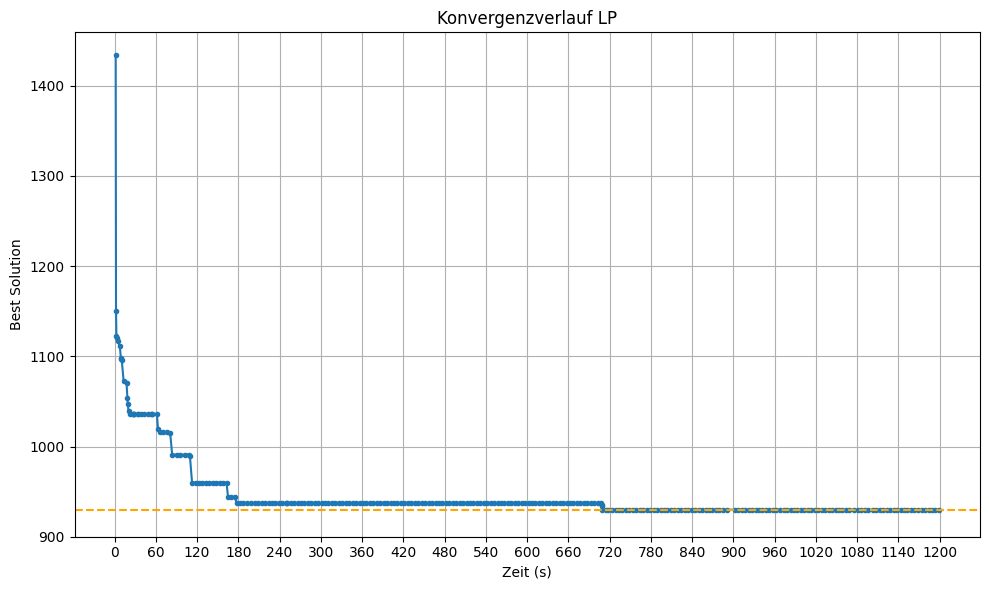

In [24]:

def plot_bestsol(df, time_col="Time", bestsol_col="BestSol", subtitle = "", y_step=100, y_min=900, y_max = 1500, max_time=None, x_step=60):
    df = df.copy()

    # Filtere Zeilen nach max_time (wenn gesetzt)
    if max_time is not None:
        df = df[df[time_col] <= max_time]

    # Y-Achsenbereich vorbereiten
    plt.figure(figsize=(10, 6))
    plt.plot(df[time_col], df[bestsol_col], marker=".")

     # Orange Linie bei 930
    plt.axhline(930, color="orange", linestyle="--", label="Zielwert 930")
    
    plt.xlabel("Zeit (s)")
    plt.ylabel("Best Solution")
    plt.title(f"Konvergenzverlauf {subtitle}")
    plt.grid(True)

    # Y-Ticks
    plt.yticks(ticks=range(y_min, y_max, y_step))

    # X-Ticks in x_step-Schritten
    x_max = max_time if max_time is not None else int(df[time_col].max())
    plt.xticks(ticks=range(0, x_max + x_step , x_step))

    plt.tight_layout()
    plt.show()



plot_bestsol(df_highs_log, subtitle = "LP", max_time= 60*20)


## CP (CP-SAT)

In [11]:
file_path = logs_path / "makespan_cp.log"

# Datei einlesen
with open(file_path, "r") as file:
    content = file.read()


# Zeilen, die mit "#Bound" beginnen
bound_lines = []
with open(file_path, "r") as file:
    for line in file:
        if line.lstrip().startswith("#Bound"):
            bound_lines.append(line.rstrip())


# Regex für Zeit und Bestwert
pattern = re.compile(r"#Bound\s+([\d.]+)s\s+best:([\dinf]+)")

# Ergebnisse extrahieren
records = []
for line in bound_lines:
    match = pattern.search(line)
    if match:
        time_sec = float(match.group(1))
        best_val = match.group(2)
        best_val = None if best_val == "inf" else int(best_val)
        records.append({"Time": time_sec, "BestSol": best_val})

# In DataFrame überführen
df_cp_logs = pd.DataFrame(records)
df_cp_logs = df_cp_logs[df_cp_logs["BestSol"].notna()].reset_index(drop=True)
df_cp_logs

,Time,BestSol
0,0.01,1108.0
1,0.05,1070.0
2,0.07,1060.0
3,0.07,1060.0
4,0.07,1060.0
...,...,...
20,0.96,938.0
21,1.80,930.0
22,2.88,930.0
23,3.93,930.0


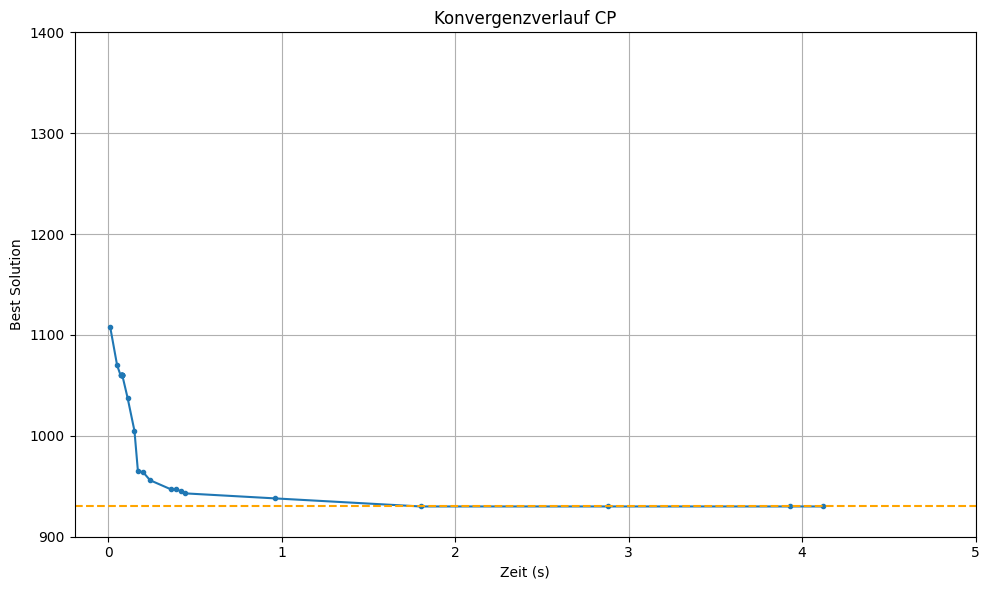

In [27]:
plot_bestsol(df_cp_logs, subtitle = "CP", x_step=1, max_time=5)